In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sy
from datetime import datetime as dt 

from scipy.optimize import curve_fit

import pandas as pd  # data parsing library
from matplotlib import cm, colors

from glob import glob

from scipy.stats.stats import pearsonr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [504]:
filename = './output/AllRun.txt'

df = pd.read_csv(filename,delimiter='\t', header=0, usecols=['date','lat','alt','H','E','DSi','count','tdelta'],
                 )  

#df['tdelta'].loc[df['tdelta']==600] = 300
df['count'] = df['count'].div(df['tdelta'])
df = df.loc[df['alt'] > 30500]
df = df.loc[df['count'] > 1.4]

df.index = pd.to_datetime(df.index)
df = df.set_index('date')


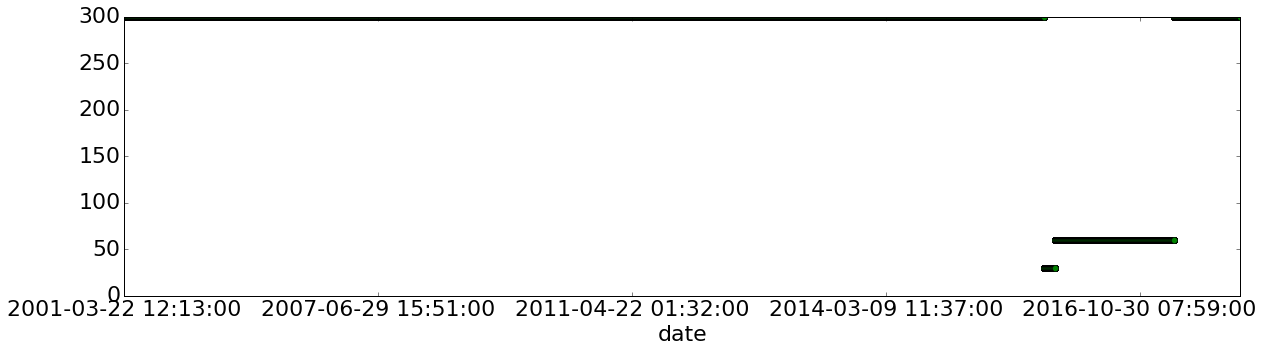

In [505]:
#dfselected.loc[dfselected['tdelta']>300]
#df = df.reset_index()
#df['date'] = pd.to_datetime(df['date'])

#df = df.set_index('date')
#df = df.sort_index()

#plt.scatter(df['date'].loc[df['tdelta']<600],df['tdelta'].loc[df['tdelta']<600])
plt.figure(figsize=(20, 5))
#df['tdelta'].loc[df['tdelta']<1000].plot(marker='.',linewidth=0)
df['tdelta'].plot(linestyle='', marker='o',color='green')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0194399038258


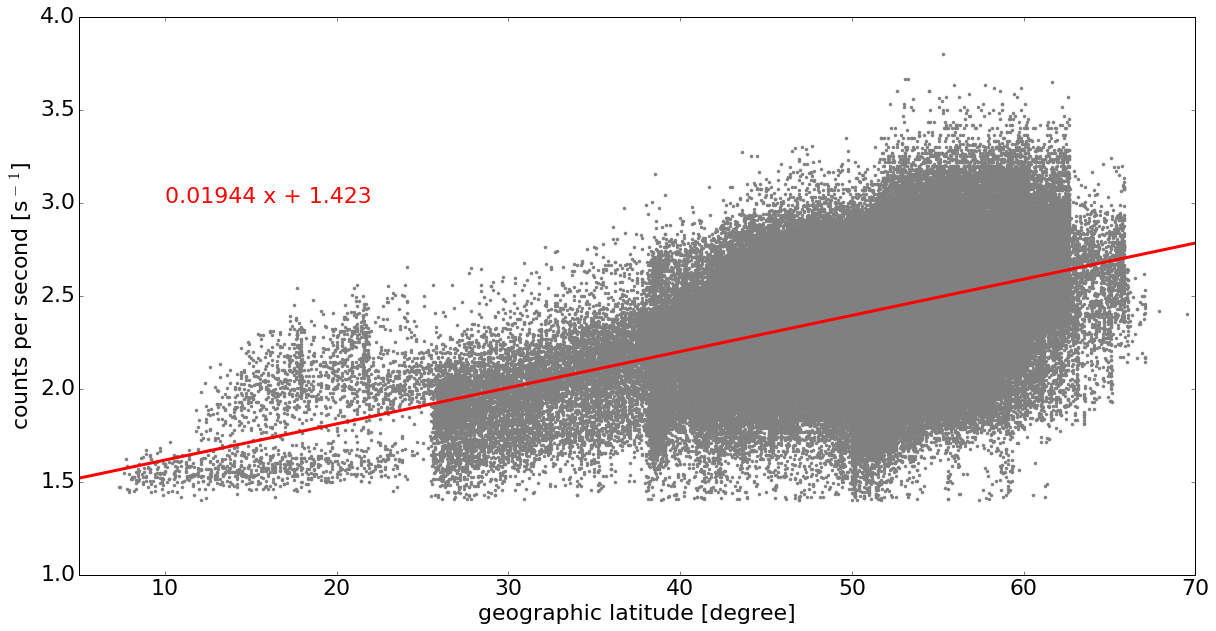

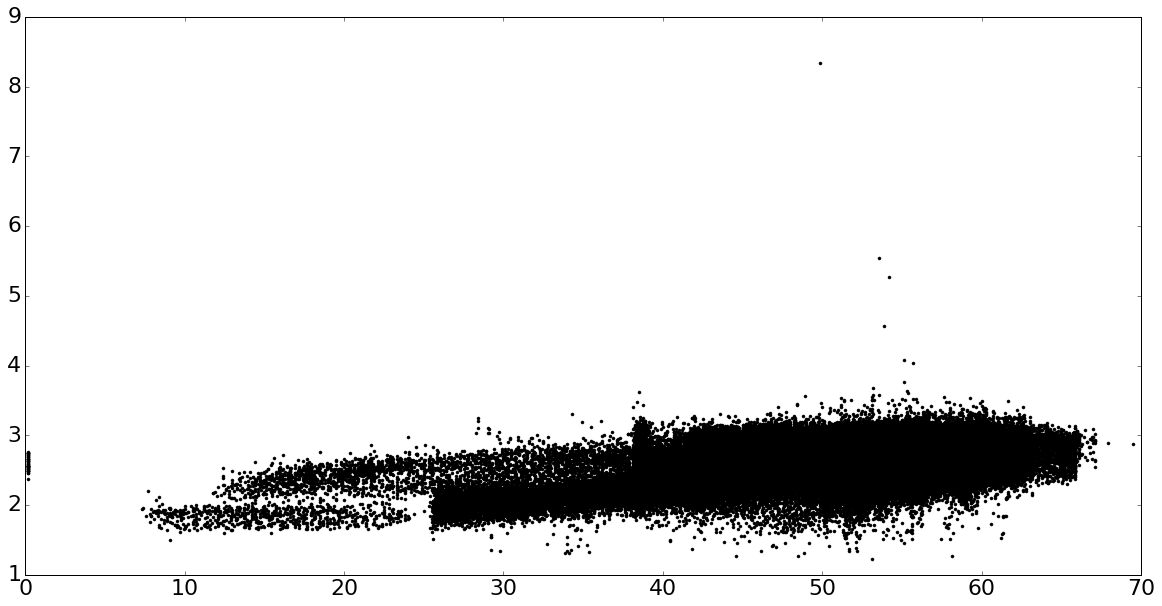

In [535]:
# find latitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})

dflat = df#.loc[df['alt'] > 30500]
#dflat = dflat.loc[dflat['count'] > 1.3]
#dflat = dfalt.loc[dfalt['count'] > 0].loc[dfalt['tdelta'] <= 600]
plt.plot(dflat['lat'],dflat['count'], linestyle='', marker='.', color='gray')

#dflat = df.loc[df['count'] > 90].loc[df['lat'] > 25].loc[df['lat'] < 63].loc[df['alt'] > 36000]
#dflat = df.loc[df['count'] < 90].loc[df['lat'] > 25].loc[df['lat'] < 70].loc[df['alt'] > 35000]
#dfselected = df.loc[df['count'] > 0.8].loc[df['count'] < 0.9].loc[df['lat'] > 50].loc[df['lat'] < 55]
#dfselected = df.loc[df['tdelta'] == 300]#.loc[df['tdelta'] < 600]
#df = df.reset_index(drop=True)
#df['date'] = pd.to_datetime(df['date'])
#df.index = pd.to_datetime(df.index)
#df = df.set_index('date')
#df = df.sort_index()


pf_coef = np.polyfit(dflat['lat'],dflat['count'],1)     # linear aproximation
p = np.poly1d(pf_coef)
plt.plot(sy.linspace(5,70), p(sy.linspace(5,70)), 'r-', c='red', lw=3)
plt.text(10,3,str(np.poly1d(pf_coef)),color='red')

#plt.text(10,3.5, r'$(' + str(round(pf_coef[0],4)) + 'x^3) + (' + str(round(pf_coef[1],2)) + ' x^2) + (' + str(round(pf_coef[2],2)) + ' x) + (' + str(round(pf_coef[3],2)) + ')$', color='red')

plt.ylim(1,4)
plt.xlim(5,70)
plt.xlabel('geographic latitude [degree]')
plt.ylabel(r'counts per second [s$^-$$^1$]')

plt.figure(figsize=(20, 10))
#dfselected = dflat['2001':'2002']
dfselected = dfalt.loc[dfalt['alt'] > 31000]
dfselected['count'] = dfselected['count'] + p(60) - pp(dfselected['alt'])
plt.plot(dfselected['lat'],dfselected['count'], linestyle='', marker='.', color='black')

print p(61)-p(60)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9.11120295939e-05


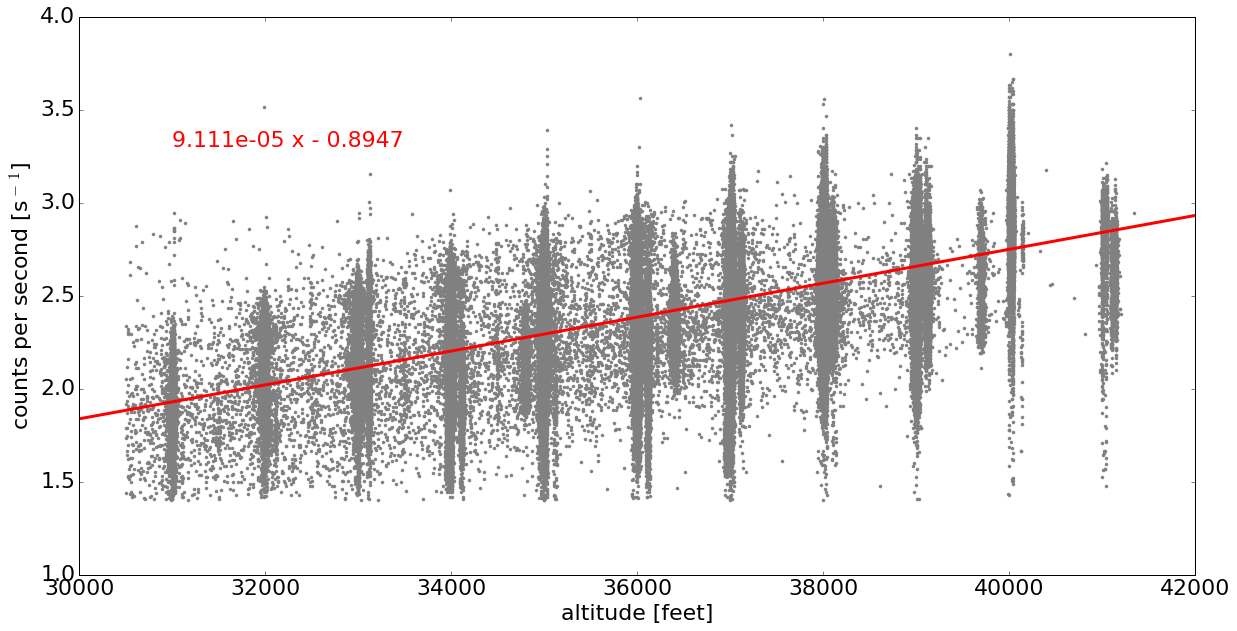

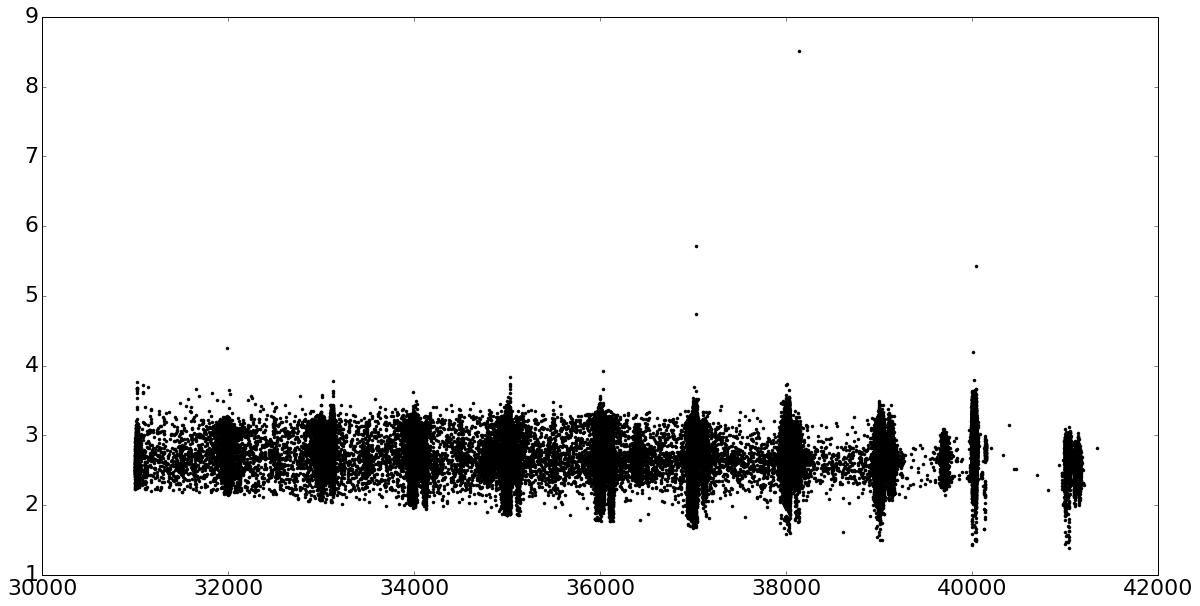

In [508]:
# find altitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})

dfalt = dflat
plt.plot(dflat['alt'],dfalt['count'], linestyle='', marker='.', color='gray')

pf_coef = np.polyfit(dflat['alt'],dflat['count'],1)     # linear aproximation
pp = np.poly1d(pf_coef)
plt.plot(sy.linspace(30000,42000), pp(sy.linspace(30000,42000)), 'r-', c='red', lw=3)
plt.text(31000,3.3,np.poly1d(pf_coef),color='red')

plt.ylim(1,4)
#plt.xlim(20000,42000)
plt.xlabel('altitude [feet]')
plt.ylabel(r'counts per second [s$^-$$^1$]')

plt.figure(figsize=(20, 10))
#dflat = df.loc[df['count'] > 90].loc[df['alt'] > 31500].loc[df['alt'] < 40500]
dfselection = dfalt.loc[dfalt['alt'] > 31000]
dfselection['count'] = dfselection['count'] + pp(40000) - pp(dfselection['alt'])
plt.plot(dfselection['alt'],dfselection['count'], linestyle='', marker='.', color='black')

print pp(40001)- pp(40000)

## subtract latitude and altitude relation


In [509]:
# subtract latitude and altitude relation

try:
    df = df.reset_index()
except:
    pass
    
# copy specific columns
df1 = df[['date','alt','lat','count']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
dfselection['count'] = dfselection['count'] + pp(40000) - pp(dfselection['alt'])

df1['count'] = df1['count'] + pp(40000) - pp(df1['alt']) # subtract altitude relation
df1['count'] = df1['count'] + p(60) - p(df1['lat']) # subtract latitude relation

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

## Calculate mean for individual flights

In [510]:
df2 = pd.read_csv('./radiation.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2['tdelta'] = (df2['date']-df2['date'].shift()).fillna(0)
df2['tdelta'] = df2['tdelta'].dt.seconds

counter = 0
suma = 0
df3 = pd.DataFrame(columns=('date','alt','lat','count','counter'))
flights = 0
for i in range(len(df2)):
    if (df2['tdelta'][i]) < 1000:
        datum = df2['date'][i]
        alt = alt + df2['alt'][i]
        lat = lat + df2['lat'][i]
        suma = suma + df2['count'][i]
        counter = counter + 1
    else:
        if counter > 0:
            df3.loc[flights] = [datum, alt/counter, lat/counter, suma/counter,counter]
            counter = 0
            suma = 0
            flights = flights + 1

df3.to_csv('./radiation_avg.csv') # save avaraged data


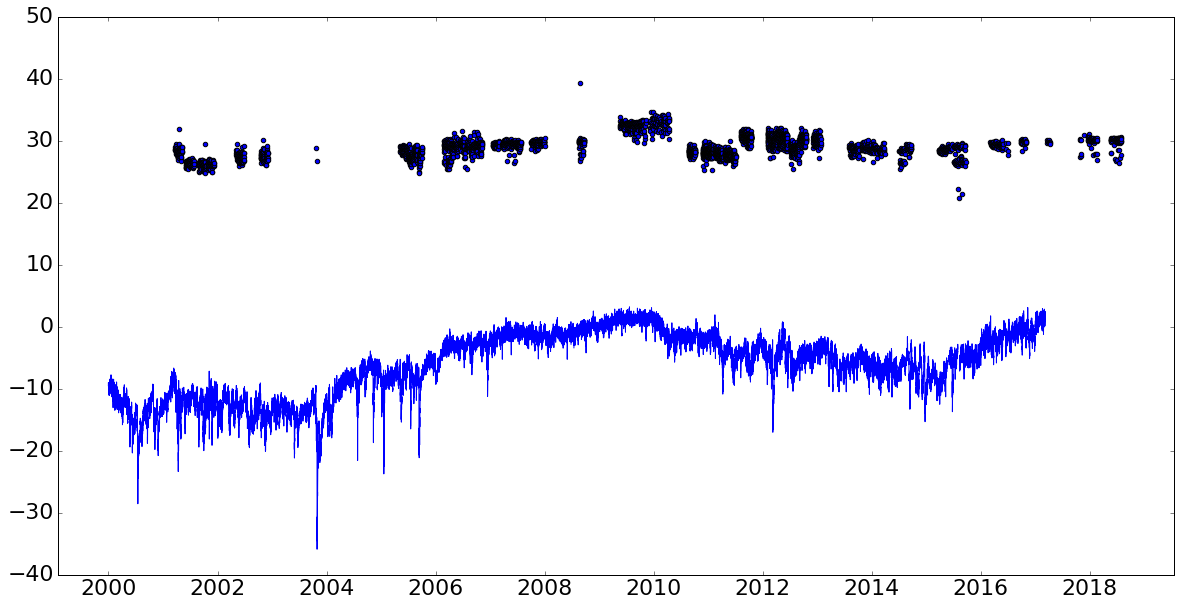

In [511]:
plt.figure(figsize=(20, 10))

df3 = pd.read_csv('./radiation_avg.csv', sep=',', header=0)#, parse_dates='time' 
df3['date'] = pd.to_datetime(df3['date'])
df3 = df3.set_index('date')
df3 = df3.sort_index()

df4 = pd.read_csv('./LSradiation.csv', sep=',', header=0)#, parse_dates='time')
df4['time'] = pd.to_datetime(df4['time'])
df4 = df4.set_index('time')
df4 = df4.sort_index()

plt.plot(df4.index,df4['FD']-100)
plt.scatter(df3.index,df3['count']*10)


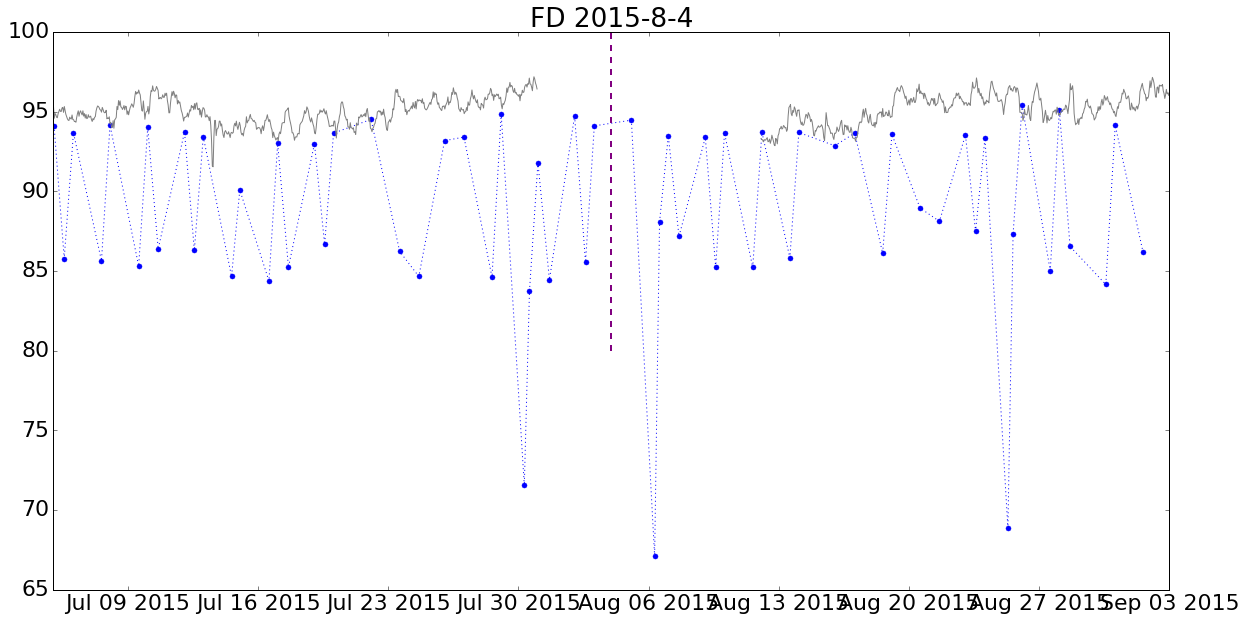

In [531]:
FD = '2001-4-12'
FD = '2012-9-4'
#FD = '2007-6-22'
#FD = '2008-8-22'
#FD = '2005-9-10'
FD = '2015-8-4'

days_view = 30

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})

df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-days_view))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=days_view))

df2['c'] = df2['count'] / (3.1/100)
df2 = df2.loc[df2['c']<110]
#df2[from_time: to_time].plot(lw='2')
plt.plot(df2[from_time: to_time].index,df2[from_time: to_time]['c'],lw='1', markersize=10,marker='.',linestyle=':')
#plt.ylim(1.5,3.2)
#plt.annotate('s', (matplotlib.dates.date2num(df2[from_time: to_time].index.to_pydatetime()), df2[from_time: to_time]['c'].tolist()))

#plt.twinx()

# Neutron monitor
# The percentages are normalized to 100 % level reached in September 1986 and represented 1,745.200 counts per hour. 
#df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(100)
plt.plot(df3[from_time: to_time].index,df3[from_time: to_time]['FD'],color='grey')
plt.title('FD ' + FD) 

plt.plot((FD,FD),(80,100), ls='--', lw=2, color='purple')

In [526]:
df2[from_time: to_time].index

DatetimeIndex(['2015-07-05 00:48:00', '2015-07-05 13:53:00',
               '2015-07-06 01:48:00', '2015-07-07 13:58:00',
               '2015-07-08 00:58:00', '2015-07-09 13:58:00',
               '2015-07-10 01:38:00', '2015-07-10 15:08:00',
               '2015-07-12 01:08:00', '2015-07-12 13:48:00',
               '2015-07-13 01:18:00', '2015-07-14 13:48:00',
               '2015-07-15 00:28:00', '2015-07-16 14:03:00',
               '2015-07-17 01:18:00', '2015-07-17 15:13:00',
               '2015-07-19 00:48:00', '2015-07-19 13:53:00',
               '2015-07-20 01:28:00', '2015-07-22 01:48:00',
               '2015-07-23 14:43:00', '2015-07-24 15:28:00',
               '2015-07-26 00:43:00', '2015-07-27 01:43:00',
               '2015-07-28 13:53:00', '2015-07-29 01:43:00',
               '2015-07-30 07:33:00', '2015-07-30 14:13:00',
               '2015-07-31 01:08:00', '2015-07-31 15:58:00',
               '2015-08-02 00:28:00', '2015-08-02 14:33:00',
               '2015-08-

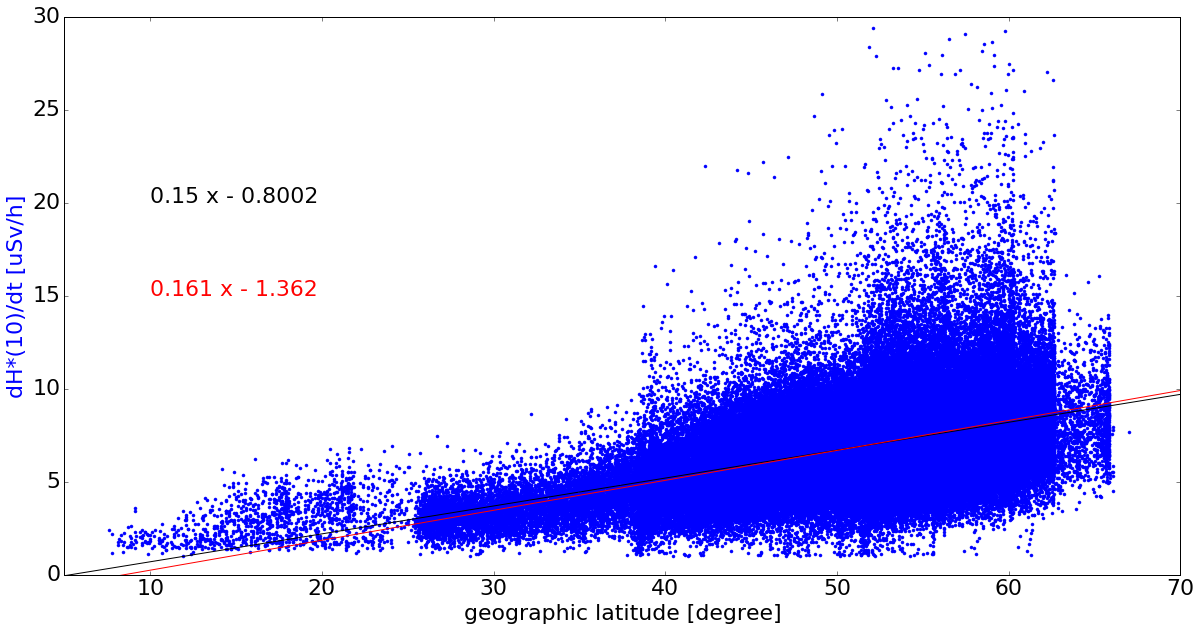

In [253]:
# find latitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})
 

plt.plot(dflat['lat'],dflat['H'], linestyle='', marker='.')

pf_coef = np.polyfit(dflat['lat'],dflat['H'],1)     # linear aproximation
p = np.poly1d(pf_coef)
plt.plot(sy.linspace(0,90), p(sy.linspace(0,90)), 'r-', c='black')
plt.text(10,20,np.poly1d(pf_coef),color='black')

pf_coef = np.polyfit(dflat['lat'].loc[dflat['lat']>=30].loc[dflat['lat']<=60],dflat['H'].loc[dflat['lat']>=30].loc[dflat['lat']<=60],1)     # linear aproximation
p = np.poly1d(pf_coef)
plt.plot(sy.linspace(0,90), p(sy.linspace(0,90)), 'r-')
plt.text(10,15,np.poly1d(pf_coef),color='r')

plt.ylim(0,30)
plt.xlim(5,70)
plt.xlabel('geographic latitude [degree]')
plt.ylabel('dH*(10)/dt [uSv/h]', color='blue')


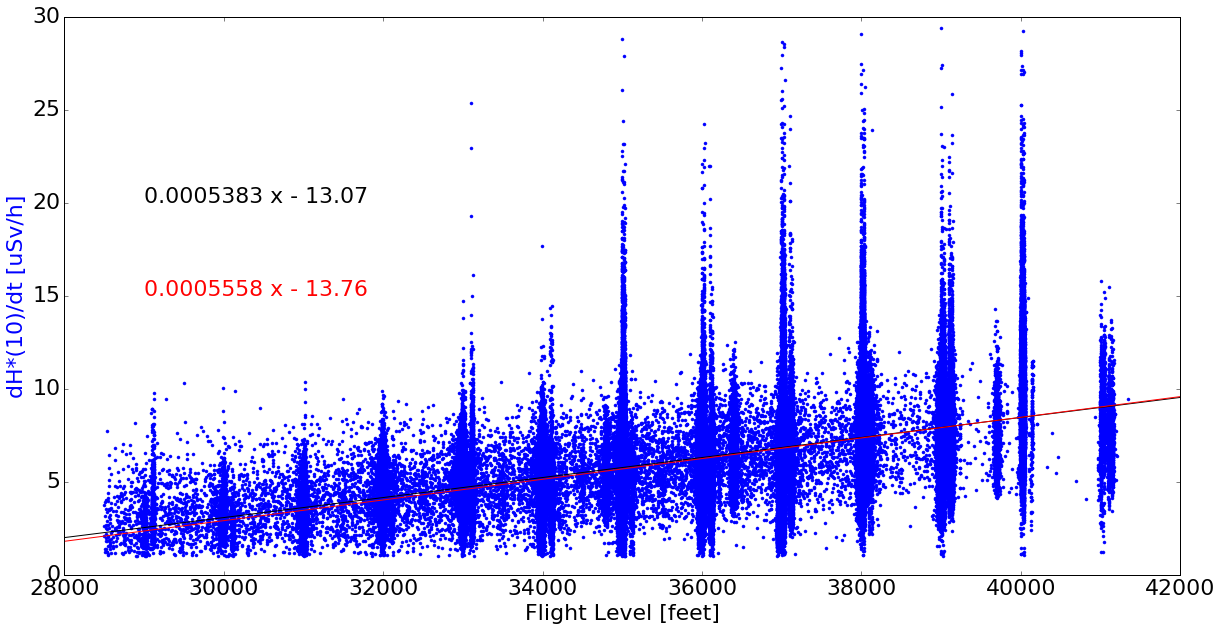

In [258]:
# find latitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})

dfalt = df[df['alt'] > 28500]
dflat = dfalt[dfalt['H'] > 1]

plt.plot(dflat['alt'],dflat['H'], linestyle='', marker='.')
plt.ylim(0,30)
#plt.xlim(28000,42000)

pf_coef = np.polyfit(dflat['alt'],dflat['H'],1)     # linear aproximation
p = np.poly1d(pf_coef)
plt.plot(sy.linspace(28000,42000), p(sy.linspace(28000,42000)), 'r-', color='black')
plt.text(29000,20,np.poly1d(pf_coef),color='black')

pf_coef = np.polyfit(dflat['alt'].loc[dflat['alt']>=33000].loc[dflat['alt']<=39000],dflat['H'].loc[dflat['alt']>=33000].loc[dflat['alt']<=39000],1)     # linear aproximation
p = np.poly1d(pf_coef)
plt.plot(sy.linspace(28000,42000), p(sy.linspace(28000,42000)), 'r-',color='r')
plt.text(29000,15,np.poly1d(pf_coef),color='r')


plt.xlabel('Flight Level [feet]')
plt.ylabel('dH*(10)/dt [uSv/h]', color='blue')



pearson:  (0.99604215591284151, 4.8330395242120534e-32) (0.91545877258019126, 3.3095395134300814e-20)
aproximation coeficients:  [ 0.14288874 -0.530395  ]


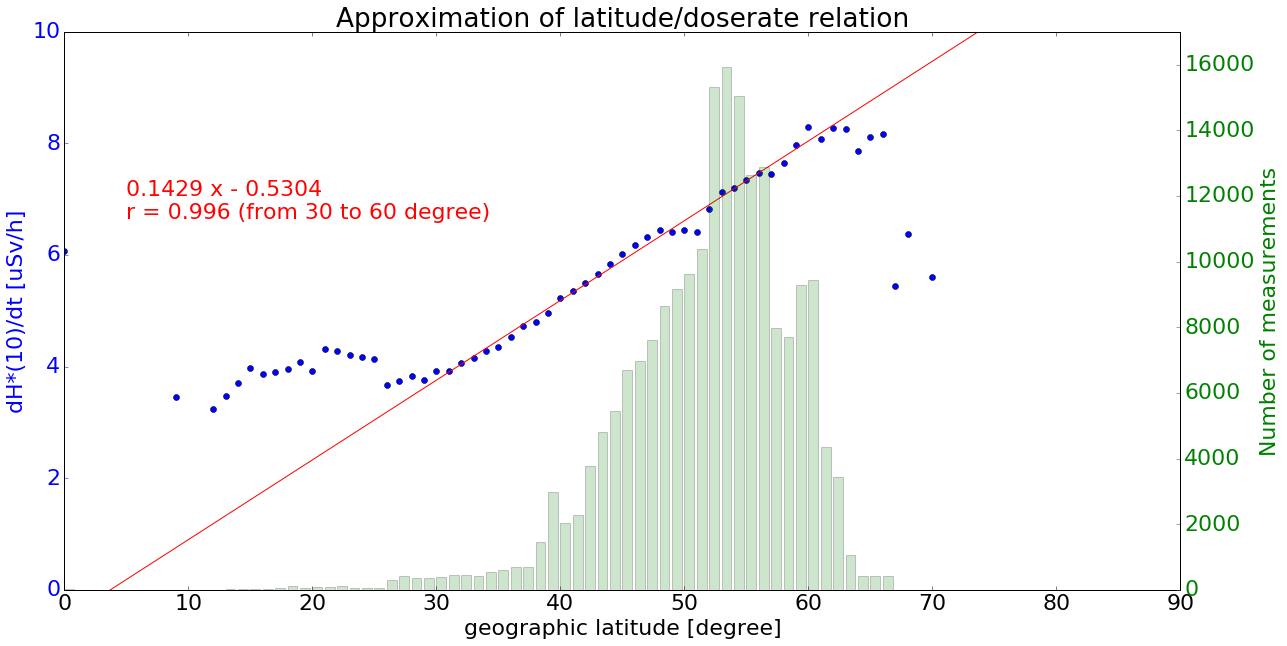

In [153]:
# find latitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})

lat_rad = np.zeros(90)
lat_num = np.zeros(90)

# sum radiation for one degree
for i in range(len(df)):
    if (df['H'][i]) > 3:
        if (df['alt'][i]) > 33000:
            lat_rad[int(round(df['lat'][i]))] += df['H'][i]
            lat_num[int(round(df['lat'][i]))] += 1
            
# average calculation
for i in range(90):
    lat_rad[i] /= lat_num[i]
            
plt.plot(lat_rad[0:90],'o')
    
pf_coef = np.polyfit(range(30,61),lat_rad[range(30,61)],1)     # linear aproximation

p = np.poly1d(pf_coef)
r = pearsonr(p(range(30,61)),lat_rad[range(30,61)])
rr = pearsonr(p(range(20,69)),lat_rad[range(20,69)])

print 'pearson: ', r, rr
print 'aproximation coeficients: ', pf_coef    # aproximation coeficients 

plt.plot(sy.linspace(0,90), p(sy.linspace(0,90)), 'r-')
plt.xlabel('geographic latitude [degree]')
plt.ylabel('dH*(10)/dt [uSv/h]', color='blue')
plt.ylim(0,10)
plt.tick_params(axis='y', colors='blue')
plt.title('Approximation of latitude/doserate relation') 
plt.twinx()
#plt.plot(lat_num, linestyle='--', color='green')
plt.bar(range(0,80),lat_num[range(0,80)], color='green', alpha=0.2)

plt.ylabel('Number of measurements',color='green')
plt.legend()
plt.ylim(0,17000)
plt.tick_params(axis='y', colors='green')
plt.text(5,12000,np.poly1d(pf_coef),color='r')
plt.text(5,11300,'r = ' + str(round(r[0],4)) + ' (from 30 to 60 degree)',color='r')

In [27]:
print p(30), lat_rad[30]
print p(35), lat_rad[35]
print p(40), lat_rad[40]

3.85104041881 3.92558722272
4.51683194407 4.3508880112
5.18262346933 5.29335803619


(0.99324445352425539, 7.1784637337155781e-06) (0.99215059674851236, 1.6452351560622838e-08)


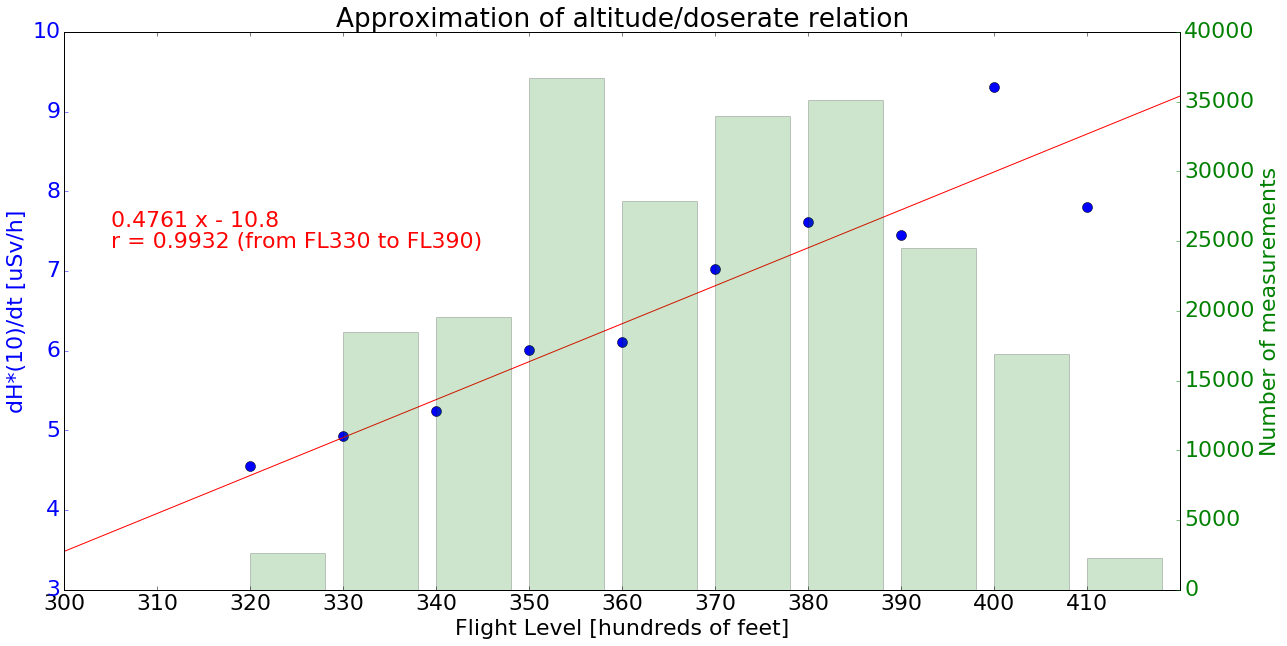

In [154]:
# find altitude relation

plt.figure(figsize=(20, 10))
matplotlib.rcParams.update({'font.size': 22})
#%pylab qt
alt_rad = np.zeros(42)
alt_num = np.zeros(42)


# sum radiation for layers per 1000-th feet
for i in range(len(df)):
    if (df['H'][i]) > 3:
        if (df['alt'][i]) > 32000:
            alt_rad[int(round(df['alt'][i] / 1000))] += df['H'][i]
            alt_num[int(round(df['alt'][i] / 1000))] += 1
            
# average calculation
for i in range(len(alt_rad)):
    alt_rad[i] /= alt_num[i]
            
plt.xlabel('Flight Level [hundreds of feet]')
plt.tick_params(axis='y', colors='blue')#, which='both', width=3, labelleft='on', labelright='off', left='on', right='off')
plt.plot(alt_rad,'o', markersize=10)
    
ppf_coef = np.polyfit(range(33,40),alt_rad[range(33,40)],1)       # linear aproximation

pp = (np.poly1d(ppf_coef))

r = pearsonr(p(range(33,40)),lat_rad[range(33,40)])
rr = pearsonr(p(range(32,42)),lat_rad[range(32,42)])
print r, rr

plt.plot(sy.linspace(30,42), pp(sy.linspace(30,42)), 'r-')
plt.ylabel('dH*(10)/dt [uSv/h]', color='blue')
#plt.tick_params(axis='y', colors='blue')
plt.title('Approximation of altitude/doserate relation') 

x = range(30,42)
labels= map(str,range(300,420,10))
plt.xticks(x, labels)


plt.twinx()

#plt.plot(range(30,42), alt_num[range(30,42)], linestyle='--', color='green')
plt.tick_params(axis='y', colors='green')#, which='both', width=3, labelleft='off', labelright='on', left='off', right='on')
plt.bar(range(30,42), alt_num[range(30,42)], color='green', alpha=0.2)#, width=0.1)
plt.ylabel('Number of measurements',color='green')
#plt.tick_params(axis='y', colors='green')
plt.text(30.5,26000,np.poly1d(ppf_coef),color='r')
plt.text(30.5,24500,'r = ' + str(round(r[0],4)) + ' (from FL330 to FL390)',color='r')
        

In [100]:
ppf_coef

array([ 0.44861623, -9.86923384])

## subtract latitude and altitude relation


In [188]:
# subtract latitude and altitude relation

df = df.reset_index()

# copy specific columns
df1 = df[['date','H','alt','lat','E']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
df1['HH'] = df1['H'] - p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'])  # subtract altitude relation
df1.loc[df1.alt <= 32000, 'HH'] = np.NAN   # filtering for low altitudes (9 754 m)

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 

# resample measurements 
df2 = pd.read_csv('./radiation.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
#df2 = df2.resample('10Min', how='mean', base=0)
df2 = df2.resample('12H', how='mean', base=0)

df2.to_csv('./radiation_avg.csv') # save avaraged data


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

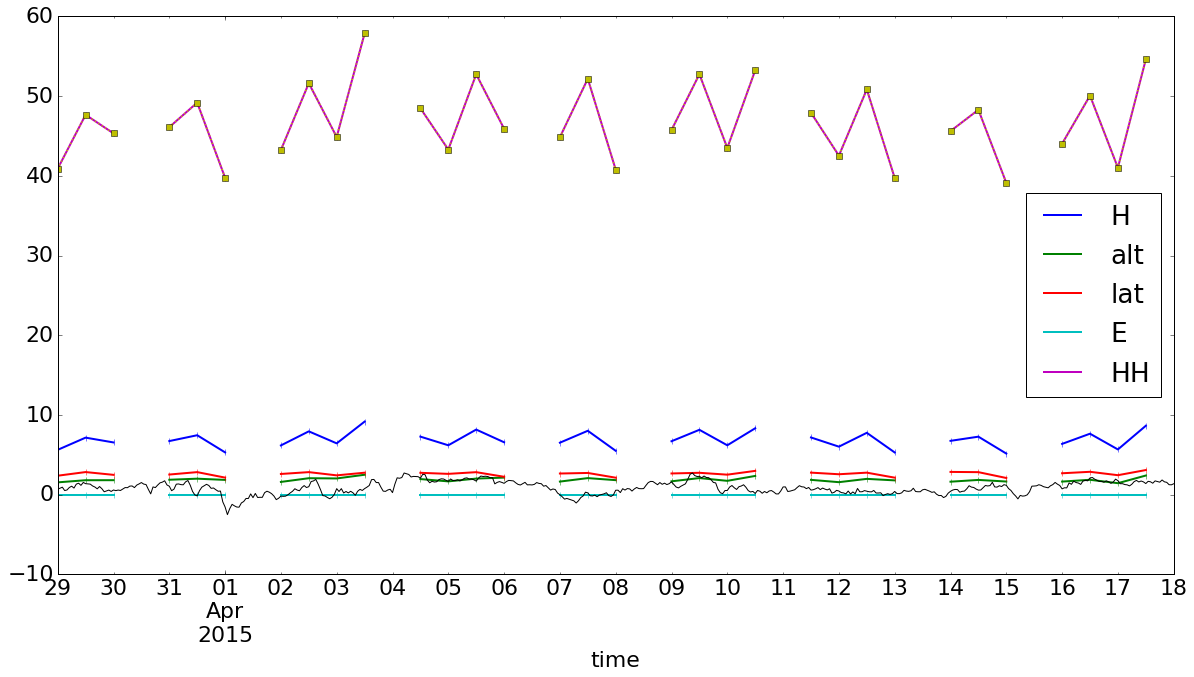

In [244]:
# subtract latitude and altitude relation and plot given date

# copy specific columns
df1 = df[['date','H','alt','lat','E']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
df1['HH'] = df1['H'] - p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'] / 1000)  # subtract altitude relation
df1.loc[df1.alt <= 32000, 'HH'] = np.NAN   # filtering for low altitudes

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 

# resample measurements 
df2 = pd.read_csv('./radiation.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
#df2 = df2.resample('60Min', how='mean', base=0)
df2 = df2.resample('12H', how='mean', base=0)

df2.to_csv('./radiation_avg.csv') # save avaraged data

# plot data for given date

#FD = '2001-11-6'
#FD = '2005-12-12'
#FD = '2012-3-8'
FD = '2015-4-8'

df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0)#, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2['H'] = df2['H'].astype(float)
df2['HH'] = df2['HH'].astype(float) * 5 + 20

df2['lat'] = df2['lat'] / 20
df2['alt'] = (df2['alt'] - 30000) / 4000

        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-10))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=10))

#df2[from_time: to_time].plot(figsize=(20,10),title=FD, marker='s',linestyle=':')
df2[from_time: to_time].plot(figsize=(20,10),lw='2',marker='|')
df2['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':')
df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(90)
df3[from_time: to_time]['FD'].plot(figsize=(20, 10))

In [348]:
#FD = '2001-5-1'
#FD = '2012-9-4'
FD = '2007-6-22'

days_view = 30


df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2['H'] = df2['H'].astype(float)
df2['HH'] = df2['HH'].astype(float) #* 5 + 40

df2['lat'] = df2['lat'] / 20
df2['alt'] = (df2['alt'] - 30000) / 4000

        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-days_view))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=days_view))

#df2[from_time: to_time].plot(figsize=(20,10),title=FD, marker='s',linestyle=':')
df2[from_time: to_time].plot(figsize=(20,10),lw='2')
df2['HH'][from_time: to_time].plot(figsize=(20,10),lw='2', marker='s',linestyle=':')
# Neutron monitor normalisation
# The percentages are normalized to 100 % level reached in September 1986 and represented 1,745.200 counts per hour. 
df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(100)
df3[from_time: to_time]['FD'].plot(figsize=(20, 10))
plt.title('FD ' + FD) 

plt.plot((FD,FD),(-5,5), ls='--', lw=2, color='purple')

KeyError: 'H'

## NMLS(count) + Liulin(count)

In [182]:
#df1['count']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

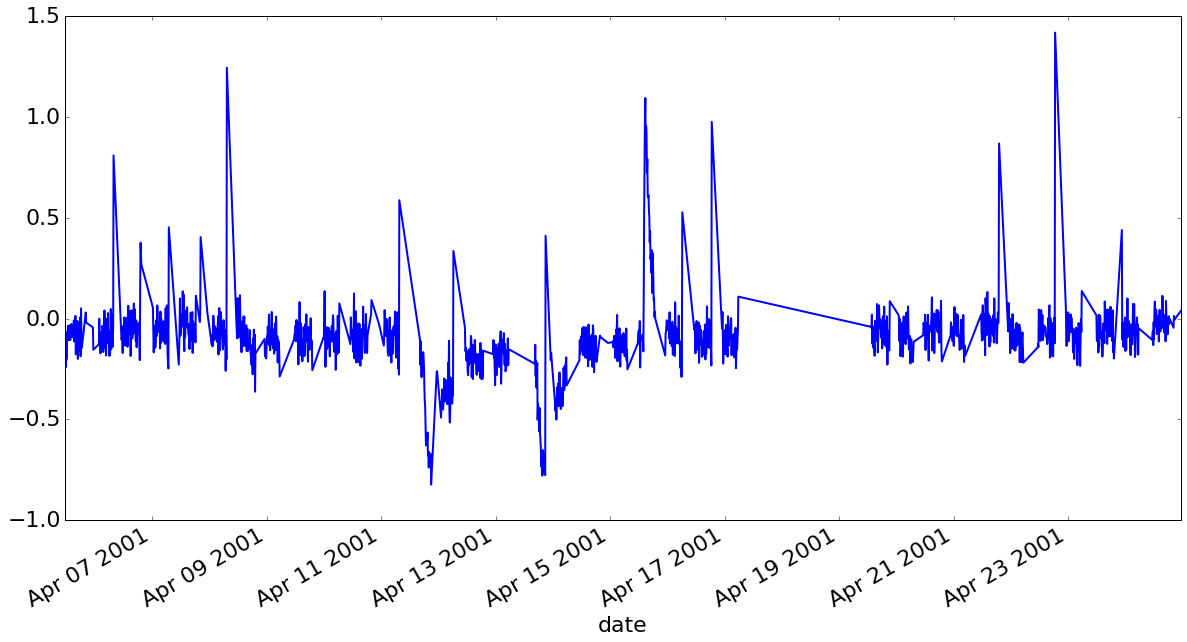

In [245]:
FD = '2001-4-15'
days_view = 10

# copy specific columns
df1 = df[['date','H','alt','lat','E','count']]

df1['date'] = pd.to_datetime(df1['date'])
df1['HH'] = df1['count'] #- p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'])  # subtract altitude relation

df1 = df1.set_index('date')
df1 = df1.sort_index()

datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-days_view))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=days_view))

(df1[from_time: to_time]['HH']).plot(figsize=(20,10),lw='2')


In [148]:
# subtract latitude and altitude relation

# copy specific columns
df1 = df[['date','H','alt','lat','E','count']]

#df1.loc[df1.H <= 3, 'HH'] = np.NAN   # filtering of low radiation
df1['date'] = pd.to_datetime(df1['date'])
#percent = 5.54 /100 # H on '2007-06-22 00:01:00'
df1['HH'] = df1['count']- p(df1['lat']) # subtract latitude relation
df1['HH'] = df1['HH'] - pp(df1['alt'])  # subtract altitude relation
df1.loc[df1['alt'] <= 32000, 'HH'] = np.NAN   # filtering for low altitudes (9 754 m)
df1.loc[df1['count'] <= 100, 'HH'] = np.NAN   # filtering for low altitudes (9 754 m)

df1 = df1.set_index('date')
df1 = df1.sort_index()

df1.to_csv('./radiation.csv') # save data 

# resample measurements 
df2 = pd.read_csv('./radiation.csv', sep=',', header=0)#, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
#df2 = df2.resample('10Min', how='mean', base=0)
df2 = df2.resample('1H', how='mean', base=0)

df2.to_csv('./radiation_avg.csv') # save avaraged data


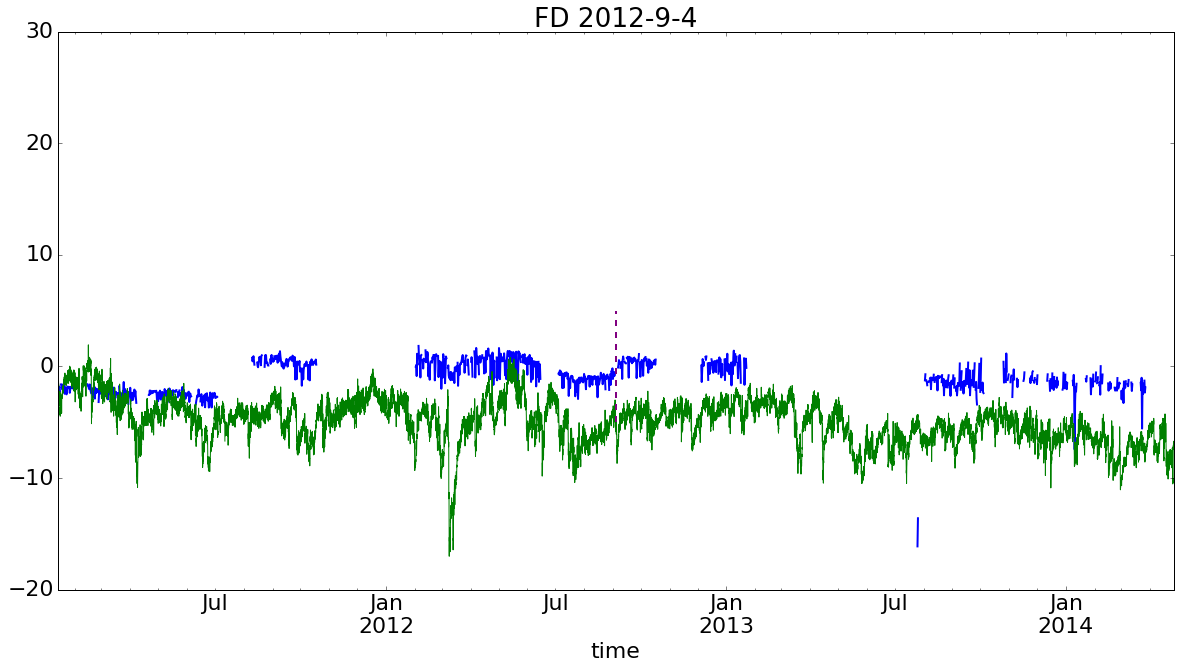

In [280]:
FD = '2001-4-15'
FD = '2012-9-4'
#FD = '2010-2-27'

days_view = 600


df3 = pd.read_csv('./LSradiation.csv', sep=',', header=0, parse_dates='time')
df3['time'] = pd.to_datetime(df3['time'])
df3 = df3.set_index('time')
df3 = df3.sort_index()

df2 = pd.read_csv('./radiation_avg.csv', sep=',', header=0, parse_dates='time' )
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2['HH'] = df2['count'].astype(float)
        
datetime.timedelta(days=1)
from_time = str(pd.to_datetime(FD) + datetime.timedelta(days=-days_view))
to_time = str(pd.to_datetime(FD) + datetime.timedelta(days=days_view))

#df2[from_time: to_time]['HH'] = df3[from_time: to_time]['HH'].sub(100)
((df2[from_time: to_time]['HH']-3)*10).plot(figsize=(20,10),lw='2')
# Neutron monitor normalisation
# The percentages are normalized to 100 % level reached in September 1986 and represented 1,745.200 counts per hour. 
#df3[from_time: to_time]['FD'] = df3[from_time: to_time]['FD'].sub(100)
(df3[from_time: to_time]['FD']-100).plot(figsize=(20, 10))
plt.title('FD ' + FD) 

plt.plot((FD,FD),(-5,5), ls='--', lw=2, color='purple')

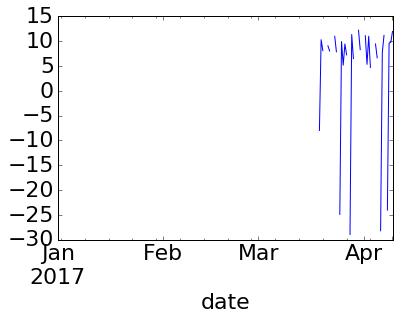

In [28]:
# all data plot

#%pylab qt

#df2.plot(figsize=(300, 10))
#df3.plot(figsize=(20, 4))
df2['HH']['2017-1-1': '2017-12-1'].plot()

In [64]:
# MAP

import cartopy.crs as ccrs  # maps plotting library
from cartopy.io.img_tiles import GoogleTiles
#from cartopy.io.img_tiles import OSMx[0:1]
from cartopy.io.srtm import srtm_composite

filename = './data/AllRun.txt'

df = pd.read_csv(filename,delimiter='\t', header=0, usecols=['date','lat','lon','alt','H'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

print filename

plt.figure(figsize=(20, 10))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
#ax.set_extent([-10, +140, 0, +90])
ax.set_extent([-160, +160, -90, +90])
#gg_tiles = GoogleTiles()
#gg_tiles = OSM()
#ax.add_image(gg_tiles, 4)
ax.coastlines()
#df = pd.read_csv(filename,sep=',', header=0 )
#df = df[df['0']>10]


#plt.scatter(lon, lat, marker=(5, 1), color='red', s=200)
#plt.title("date: " + date)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False

ax = plt.axes(projection=ccrs.PlateCarree())
#!!!!podkladova mapa ax.stock_img()

df = df.resample('1H', how='mean', base=0)

for i in range(len(df)):
    if df['H'][i] > 0:
        if df['alt'][i] > 32000:
            plt.plot(df['lon'][i], df['lat'][i],
                 color=plt.cm.jet(df['H'][i]/10), 
                 marker='.',
                 transform=ccrs.PlateCarree(), #lw=3
                 )

sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=10))
sm._A = []
cb = plt.colorbar(sm, shrink=0.7)
cb.set_label('H*(10)[uSy/h]')
plt.show()




ImportError: No module named cartopy.crs

In [74]:
range(33,38)

[33, 34, 35, 36, 37]